# Loyalty Cards

## Executive summary

In this notebook I will perform the MDE for loyalty cards experiment

## Config

In [1]:
import matplotlib.pyplot as  plt
# import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys

base_path = 'c:/Users/Jordi Cremades/Documents/Repos/customer-data-analytics-main/'
sys.path.insert(1, os.path.join(base_path, 'General/AB-tests/MDE'))
sys.path.insert(2, os.path.join(base_path, 'General/AB-tests'))

sys.path.append('c:/Users/Jordi Cremades/Documents/Repos/central-node')

from utils import query_engines
from fenix.statistical_tests import relative_ttest as t_test
from fenix.run_experiment import ExperimentConfig, MDEConfig, ExperimentRunner
from fenix.statistical_tests.stattools import StatisticalResult
from fenix.tools.helpfuncs import mde_visualization
from fenix.tools.helpfuncs import adjusted_alpha_multiple_comparison

import transformations.transformation as tr
import fenix.visual.graphs
import fenix.tools.hashing as hashing

## [X] Build the dataset

In [2]:
q = query_engines.QueryEngines(reset_query_logs=True, reset_to_load=False)

START_DATE = "'2024-05-01'"
END_DATE = "'2024-06-01'"

params = [
    # dates
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)},
]

q.prepare_query('lc_mde.sql', params=params)

df  = q.query_run_starburst( #query_run_livedb otherwise
    output_file='lc_mde',
    load_from_output_file='lc_mde',
    print_query=True
)

df.head()

,customer_id,first_exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,n_orders,n_orders_with_loyalty,n_store_views
0,162976,2024-05-17,3,4,2,1,1
1,593395,2024-05-02,1,1,1,1,1
2,593395,2024-05-02,1,2,5,3,5
3,593395,2024-05-02,1,3,9,5,12
4,593395,2024-05-02,1,4,15,7,18


In [3]:
# Definition of main metric
df['lc_pen']=df['n_orders_with_loyalty']/df['n_orders']
df['lc_pen'].fillna(0,inplace=True)
df.head()

,customer_id,first_exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,n_orders,n_orders_with_loyalty,n_store_views,lc_pen
0,162976,2024-05-17,3,4,2,1,1,0.500000
1,593395,2024-05-02,1,1,1,1,1,1.000000
2,593395,2024-05-02,1,2,5,3,5,0.600000
3,593395,2024-05-02,1,3,9,5,12,0.555556
4,593395,2024-05-02,1,4,15,7,18,0.466667


## [X] Dataset sanity check

<Axes: xlabel='first_exposure_date'>

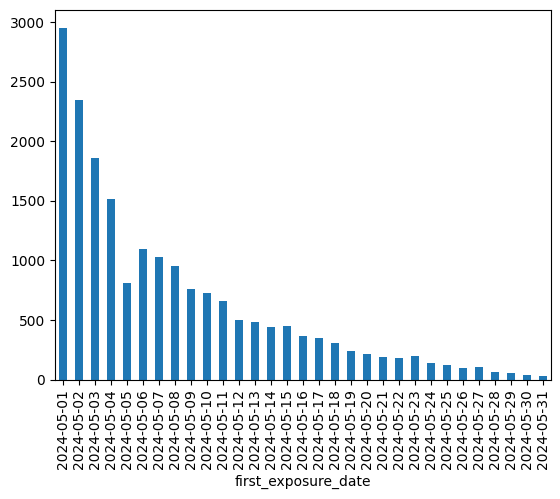

In [4]:
df.groupby('first_exposure_date').customer_id.nunique().plot(kind='bar')

<Axes: xlabel='first_exposure_date'>

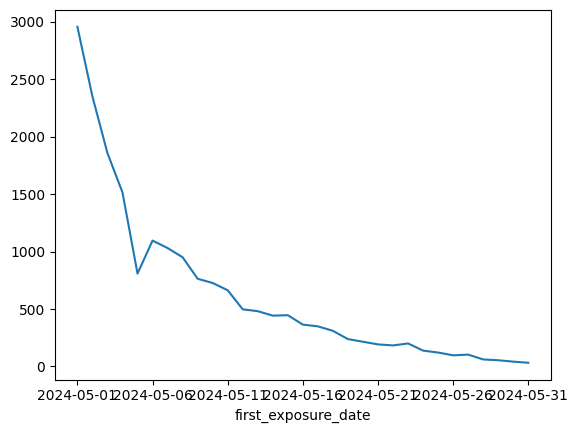

In [5]:
df.groupby('first_exposure_date').customer_id.nunique().plot(kind='line')

<Axes: xlabel='obs_week_index_since_start_date'>

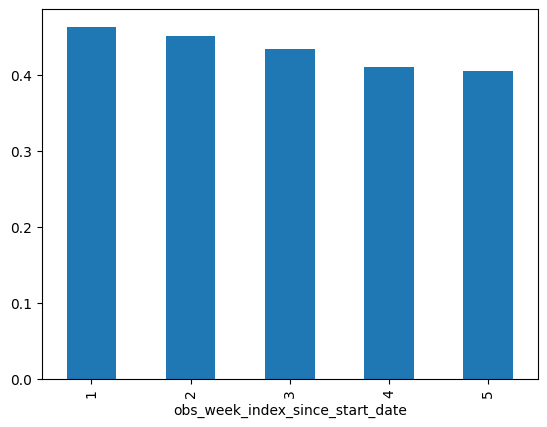

In [6]:
df.groupby('obs_week_index_since_start_date')['lc_pen'].mean().plot(kind='bar')

## Dataset simulation

In [7]:
# Synthetic LTHO group
df['ltho_group'] = df['customer_id'].apply(lambda x: hashing.hashing_function(x, 'a057353b-bdd5-41eb-b62e-d9b488b54367', (49,999)))
df['ltho_group'].value_counts(normalize=True, dropna=False)

ltho_group
variant    0.951217
control    0.048783
Name: proportion, dtype: float64

In [8]:
# Filter out customer that are in the LTHO group
df = df[df['ltho_group']=='variant']

In [9]:
df.sort_values(by='obs_week_index_since_start_date')

,customer_id,first_exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,n_orders,n_orders_with_loyalty,n_store_views,lc_pen,ltho_group
24429,148995806,2024-05-01,1,1,2,2,7,1.000,variant
26792,142868789,2024-05-03,1,1,0,0,2,0.000,variant
5443,131687727,2024-05-06,1,1,1,1,2,1.000,variant
39719,138248349,2024-05-01,1,1,3,3,16,1.000,variant
26795,154163598,2024-05-02,1,1,0,0,3,0.000,variant
...,...,...,...,...,...,...,...,...,...
24164,124318100,2024-05-01,1,5,8,3,27,0.375,variant
13081,9415795,2024-05-23,4,5,0,0,1,0.000,variant
39964,31605061,2024-05-01,1,5,3,3,5,1.000,variant
13097,19768325,2024-05-12,2,5,0,0,1,0.000,variant


### Outliers

In [10]:
sessions_outliers = tr.outliers_detection(df, 'obs_week_index_since_start_date', 'n_orders', 'n_store_views')
sessions_outliers.head()

,customer_id,first_exposure_date,exposure_week_index_since_start_date,obs_week_index_since_start_date,n_orders,n_orders_with_loyalty,n_store_views,lc_pen,ltho_group,cmperorder
22623,18744918,2024-05-01,1,5,20,17,600,0.850000,variant,30.000000
45661,126358051,2024-05-02,1,5,344,27,418,0.078488,variant,1.215116
6193,128331687,2024-05-01,1,5,16,12,360,0.750000,variant,22.500000
17992,132368218,2024-05-01,1,5,23,19,248,0.826087,variant,10.782609
38804,58818211,2024-05-01,1,5,37,18,207,0.486486,variant,5.594595


In [11]:
round(sessions_outliers['n_orders'].describe(percentiles=[0.0001,0.005,0.05,0.5,0.95,0.99, 0.999, 0.9999]))

count     10318.0
mean          5.0
std           6.0
min           1.0
0.01%         1.0
0.5%          1.0
5%            1.0
50%           3.0
95%          13.0
99%          24.0
99.9%        47.0
99.99%       76.0
max         344.0
Name: n_orders, dtype: float64

In [12]:
round(sessions_outliers['n_store_views'].describe(percentiles=[0.0001,0.005,0.05,0.5,0.95,0.99, 0.999, 0.9999]))

count     10318.0
mean         10.0
std          15.0
min           1.0
0.01%         1.0
0.5%          1.0
5%            1.0
50%           6.0
95%          32.0
99%          58.0
99.9%       134.0
99.99%      416.0
max         600.0
Name: n_store_views, dtype: float64

In [13]:
outliers_rules = (sessions_outliers['n_orders']>70)|(sessions_outliers['n_store_views']>400)
outliers_customers = list(set(sessions_outliers[outliers_rules]['customer_id']))

In [14]:
outliers_customers

[42453238, 126358051, 18744918]

In [15]:
mde_df_clean = df[~df['customer_id'].isin(outliers_customers)].copy()

In [16]:
print(f"We filtered {(len(outliers_customers))/df['customer_id'].nunique():2%} customers")

We filtered 0.016384% customers


## MDE

In [17]:
variants_params = {
    'control': 0.5,
    'variant': 0.5,
    }

In [18]:
SALT = '51231965-8f49-450a-8bea-42d32eefee8f'
# calculate bounds tuples for the smallest group automatically from variants_params
# this function will automatically assign to the variant group the smallest variation
bounds_tuples = hashing.calculate_upper_bounds(variants_params, comparison_between_groups=True)

mde_df_clean['exp_group'] = mde_df_clean['customer_id'].apply(lambda x: hashing.hashing_function(x, SALT, bounds_tuples))

In [19]:
mde_df_clean['exp_group'].value_counts(normalize=True, dropna=False)

exp_group
variant    0.507455
control    0.492545
Name: proportion, dtype: float64

In [20]:
#MDE for primary metrics
#alpha adjusted will be calculated automatically
mde_configuration = {
    "metrics_to_mde": [
                       ('n_orders_with_loyalty', 'n_orders'),
                       ],
    "experiment_days": [1, 2, 3, 4],
    "compare_between_groups": True,
    #important parameter when you launch a product feature only for new app versions
    "is_new_app_version": True
    }

mde_accuracy = {
    "initial_alpha": 0.05, #false positives
    "beta": 0.20 #false negatives
    }

#the alpha will be adjusted automatically if you have several metrics and several variants
#put compare_between_groups=True if you want to compare metrics between variants as well
mde_accuracy = adjusted_alpha_multiple_comparison(variants_params, mde_configuration , mde_accuracy)

mde_accuracy

We have 2 variants and 1 metrics which translates to 1 total comparisons. The adjusted alpha is 0.05 from the initial alpha of 0.05


{'initial_alpha': 0.05, 'beta': 0.2, 'total_comparisons': 1, 'alpha': 0.05}

In [21]:
%%time
# configure and run MDE analysis

experiment_config = ExperimentConfig(
    metric_list = mde_configuration['metrics_to_mde'],
    user_dimensions = [],
    alpha = mde_accuracy['alpha']
)

mde_config = MDEConfig(
    experiment_config = experiment_config,
    experiment_days = mde_configuration['experiment_days'],
    power = 1 - mde_accuracy['beta'],
    compare_between_groups = mde_configuration['compare_between_groups']
)

mde_df_clean.rename(columns={
    'exposure_week_index_since_start_date':'diff_exposure_days',
    'obs_week_index_since_start_date':'experiment_days'
}, inplace=True)

first_launch_mde = ExperimentRunner.run_aa(mde_df_clean, mde_config)

CPU times: total: 141 ms
Wall time: 175 ms


In [22]:
# Convert to a DataFrame
first_launch_mde = pd.DataFrame(first_launch_mde)

In [23]:
first_launch_mde['abs_mde'] = round(first_launch_mde['control_metric'] * first_launch_mde['rel_mde'],5)
first_launch_mde['rel_mde_perc'] = round(first_launch_mde['rel_mde'] * 100,2)
first_launch_mde[['duration', 'metric_name', 'control_metric', 'test_metric', 'rel_mde_perc', 'abs_mde']]

,duration,metric_name,control_metric,test_metric,rel_mde_perc,abs_mde
0,1,n_orders_with_loyalty / n_orders,0.621930,0.615084,6.62,0.04118
1,2,n_orders_with_loyalty / n_orders,0.618921,0.621806,4.94,0.03060
2,3,n_orders_with_loyalty / n_orders,0.621727,0.615998,4.32,0.02687
3,4,n_orders_with_loyalty / n_orders,0.617574,0.617807,4.11,0.02537


In [24]:
## Rename metrics
first_launch_mde['metric_name'] = first_launch_mde['metric_name'].replace({
    'n_orders_with_loyalty / n_orders': 'Loyalty Card Pen.',
})

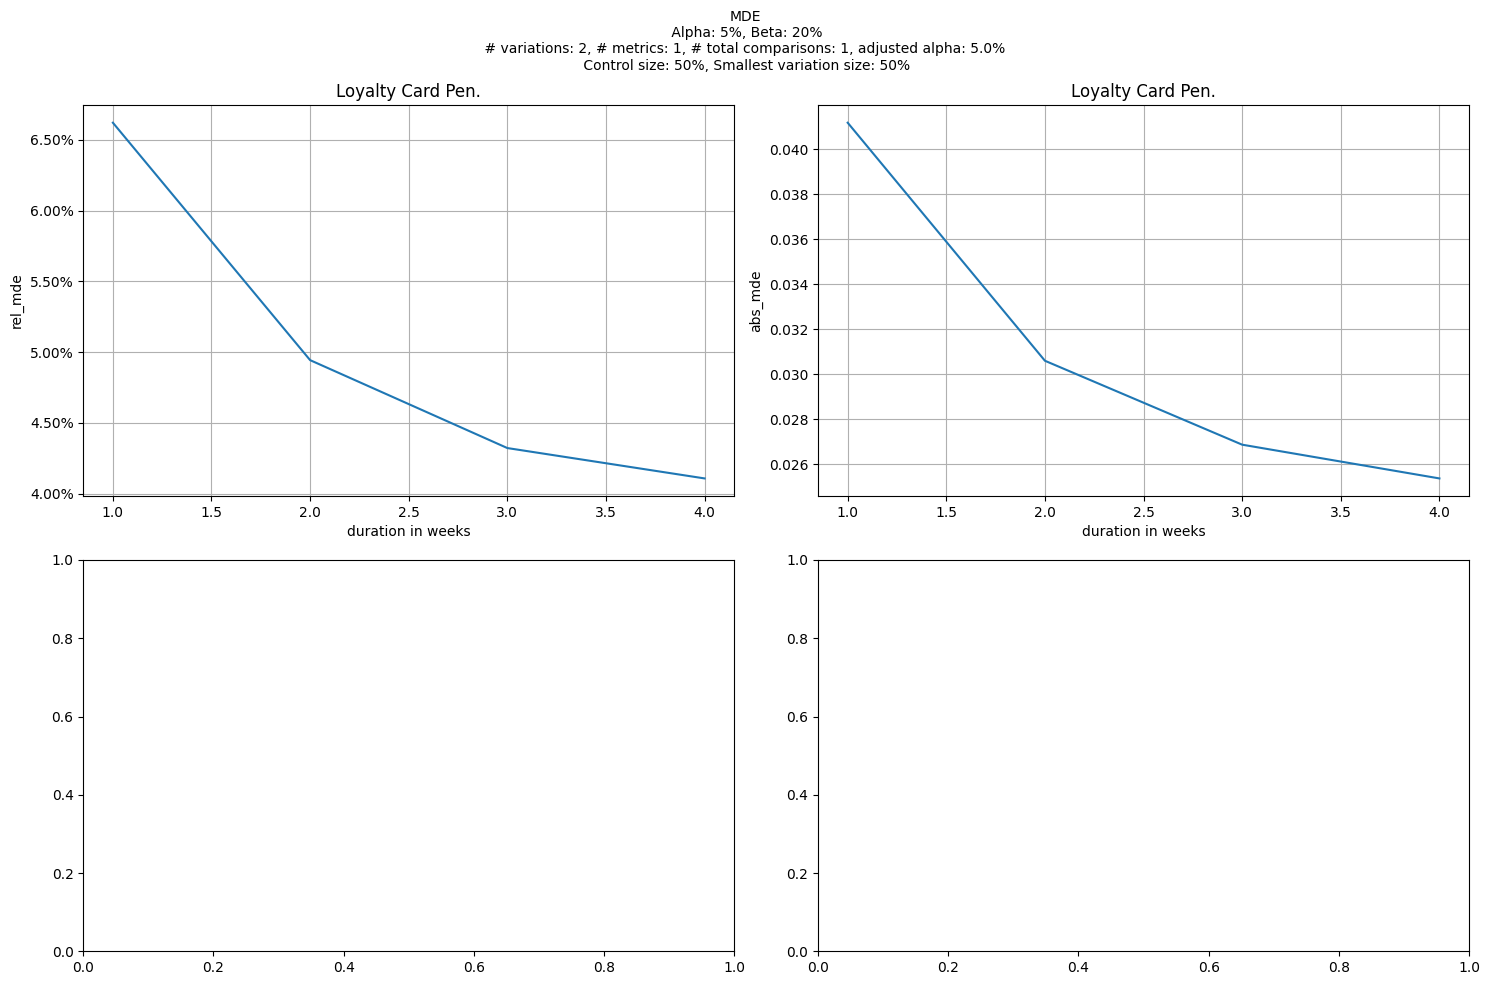

In [26]:

from matplotlib.ticker import FuncFormatter

metrics = first_launch_mde.metric_name.unique().tolist()

nrows = len(metrics) + 1 # Because I only have one metric and this is breaking the axis script
ncols = 2

fig,axs = plt.subplots(nrows, ncols, figsize=(15,5*nrows))

for i, metric in enumerate(metrics):
    ax_left=axs[i,0]
    ax_right=axs[i,1]
    ax_left.set_title(f"{metric}", fontsize=12)
    ax_right.set_title(f"{metric}", fontsize=12)
    ax_left.set_xlabel('duration in weeks')
    ax_right.set_xlabel('duration in weeks')
    vals = ax_left.get_yticks()
    ax_left.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax_right.set_title(f"{metric}", fontsize=12)
    sns.lineplot(data=first_launch_mde.query(f"metric_name=='{metric}'"), x='duration', y='rel_mde', ax=ax_left)
    sns.lineplot(data=first_launch_mde.query(f"metric_name=='{metric}'"), x='duration', y='abs_mde', ax=ax_right)
    
    ## add gridlines
    ax_left.grid(True)
    ax_right.grid(True)

    suptitle=f"MDE\n Alpha: {int(mde_accuracy['initial_alpha']*100)}%, Beta: {int(mde_accuracy['beta']*100)}%\n # variations: {len(variants_params.keys())}, # metrics: {len(mde_configuration['metrics_to_mde'])}, # total comparisons: {mde_accuracy['total_comparisons']}, adjusted alpha: {round(mde_accuracy['alpha'],3)*100}% \n Control size: {int(variants_params['control']*100)}%, Smallest variation size: {int(min(list(variants_params.values())[1:])*100)}%"

    plt.suptitle(suptitle, fontsize=10)

plt.tight_layout()
plt.show()